In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [9]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"], index_col="Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<AxesSubplot: xlabel='Date'>

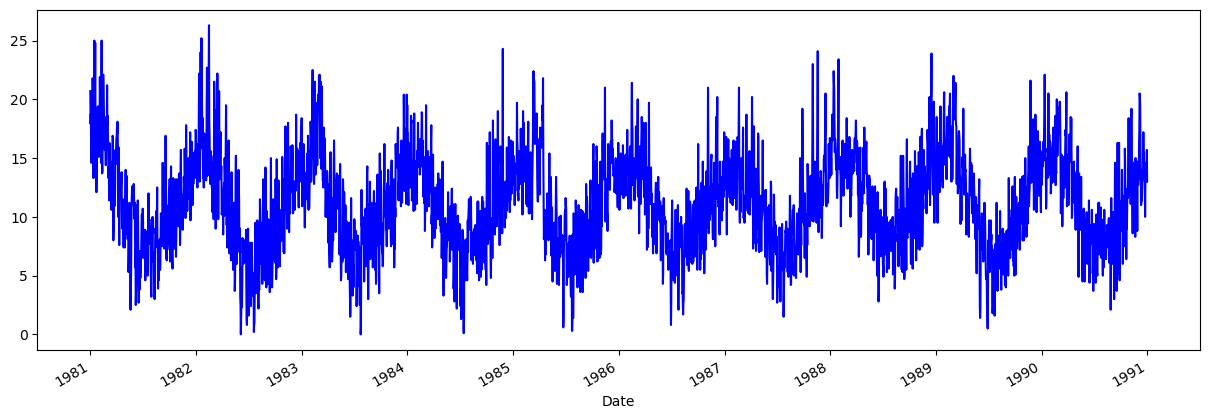

In [10]:
df.Temp.plot(figsize=(15, 5), color='b')

# Dataset Splitting

In [11]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [7]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [12]:
seq_len = 14
bs =32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)


(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [14]:
from jcopdl.layers import linear_block

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden


In [16]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0,
    "seg_len": train_set.n_seq
})


# Training Preparation -> MCOC

In [17]:
model = LSTM(
    config.input_size,
    config.output_size,
    config.hidden_size,
    config.num_layers,
    config.dropout
).to(device)

criterion = nn.MSELoss(reduction="mean")

optimizer = optim.AdamW(model.parameters(), lr=0.001)

callback = Callback(model, config, outdir="model/lstm")

# Training

In [18]:
from tqdm.auto import tqdm

In [19]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    
    cost = 0.0

    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]

    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 137.0444 | Test_cost  = 138.5768 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 123.4479 | Test_cost  = 117.8757 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 100.7927 | Test_cost  = 93.9938 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 79.9315 | Test_cost  = 75.7714 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 64.4805 | Test_cost  = 62.5182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 53.5051 | Test_cost  = 53.0925 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 45.7245 | Test_cost  = 46.2790 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 40.0340 | Test_cost  = 41.0424 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 35.6027 | Test_cost  = 36.8218 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 32.0303 | Test_cost  = 33.3550 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 29.1136 | Test_cost  = 30.4828 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 26.7109 | Test_cost  = 28.0642 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 24.7103 | Test_cost  = 26.0484 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 23.0889 | Test_cost  = 24.4130 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 21.7957 | Test_cost  = 23.0898 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 20.7704 | Test_cost  = 22.0250 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 19.9637 | Test_cost  = 21.1727 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 19.3334 | Test_cost  = 20.4934 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 18.8441 | Test_cost  = 19.9538 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 18.4661 | Test_cost  = 19.5260 | 


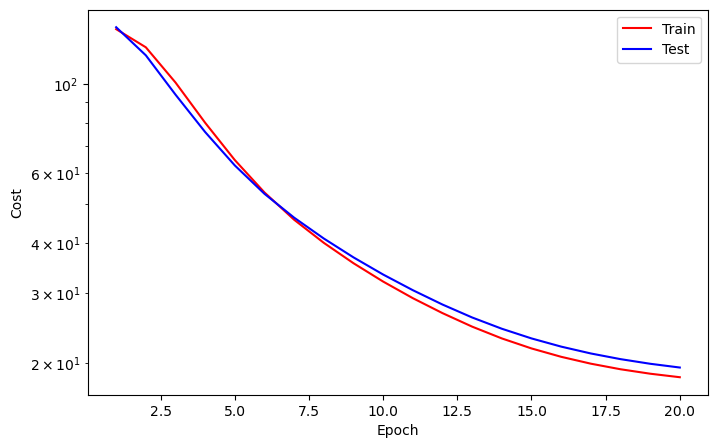

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 18.1747 | Test_cost  = 19.1868 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 17.9500 | Test_cost  = 18.9174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 17.7763 | Test_cost  = 18.7027 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 17.6411 | Test_cost  = 18.5305 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 17.5347 | Test_cost  = 18.3915 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 17.4498 | Test_cost  = 18.2781 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 17.3809 | Test_cost  = 18.1847 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 17.3240 | Test_cost  = 18.1070 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 17.2762 | Test_cost  = 18.0418 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 17.2352 | Test_cost  = 17.9868 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 17.1993 | Test_cost  = 17.9400 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 17.1673 | Test_cost  = 17.8999 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 17.1379 | Test_cost  = 17.8649 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 17.1097 | Test_cost  = 17.8328 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 17.0797 | Test_cost  = 17.7956 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 17.0391 | Test_cost  = 17.6950 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 16.9911 | Test_cost  = 17.7399 | 
==> EarlyStop patience =  1 | Best test_cost: 17.6950


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 16.9796 | Test_cost  = 17.6390 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 16.8654 | Test_cost  = 17.3647 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 16.6731 | Test_cost  = 17.2318 | 


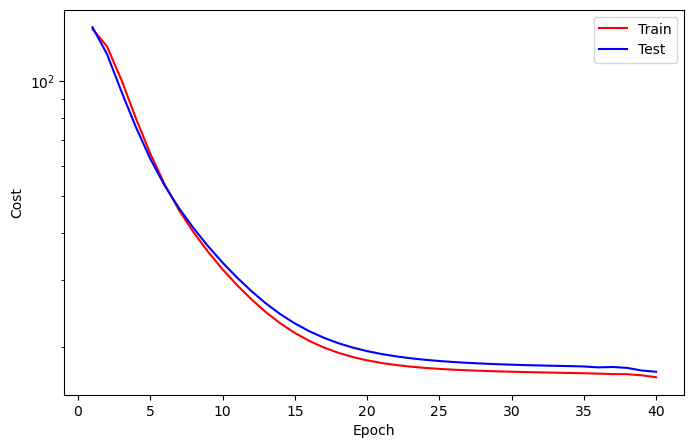

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 16.5626 | Test_cost  = 17.1028 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 16.4628 | Test_cost  = 17.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 16.3810 | Test_cost  = 16.8790 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 16.2614 | Test_cost  = 16.7755 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 16.1510 | Test_cost  = 16.6679 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 16.0615 | Test_cost  = 16.5613 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 15.9748 | Test_cost  = 16.4681 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 15.8917 | Test_cost  = 16.3806 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 15.8024 | Test_cost  = 16.2779 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 15.7246 | Test_cost  = 16.1843 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 15.6521 | Test_cost  = 16.1067 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 15.5670 | Test_cost  = 16.0140 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 15.4983 | Test_cost  = 15.9392 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 15.4194 | Test_cost  = 15.8521 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 15.3404 | Test_cost  = 15.7409 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 15.2413 | Test_cost  = 15.6473 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 15.1472 | Test_cost  = 15.5245 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 15.0418 | Test_cost  = 15.4036 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 14.8859 | Test_cost  = 15.1821 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 14.6363 | Test_cost  = 14.8178 | 


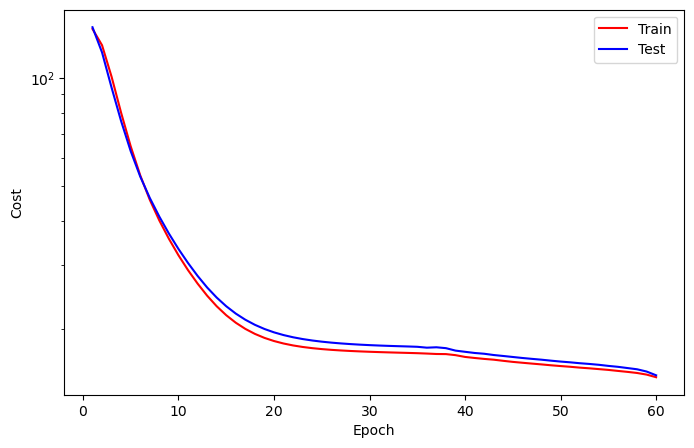

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 14.2198 | Test_cost  = 14.1213 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 13.3256 | Test_cost  = 12.7486 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 12.1962 | Test_cost  = 12.0923 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 11.7503 | Test_cost  = 11.3415 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 11.0472 | Test_cost  = 10.8658 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 10.5865 | Test_cost  = 10.3498 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 10.1832 | Test_cost  = 9.7737 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 9.6999 | Test_cost  = 9.3184 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 9.2654 | Test_cost  = 8.9312 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 8.9797 | Test_cost  = 8.5926 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 8.7343 | Test_cost  = 8.2745 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 8.4923 | Test_cost  = 8.0192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 8.2816 | Test_cost  = 7.8098 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 8.1186 | Test_cost  = 7.6232 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 7.9806 | Test_cost  = 7.4523 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 7.8551 | Test_cost  = 7.2996 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 7.7376 | Test_cost  = 7.1634 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 7.6317 | Test_cost  = 7.0426 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 7.5382 | Test_cost  = 6.9340 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 7.4555 | Test_cost  = 6.8360 | 


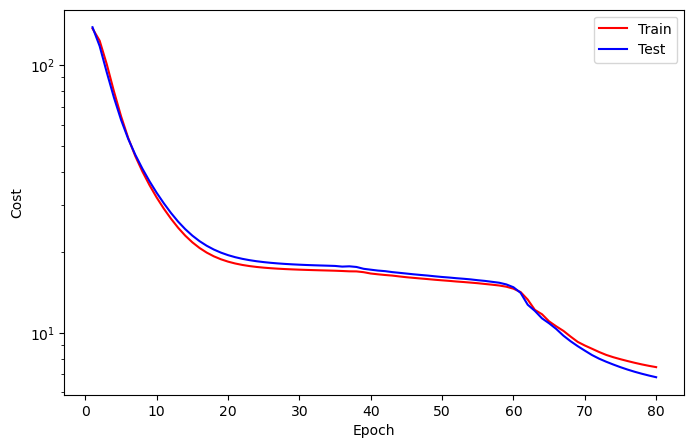

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 7.3810 | Test_cost  = 6.7464 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 7.3129 | Test_cost  = 6.6653 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 7.2504 | Test_cost  = 6.5915 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 7.1933 | Test_cost  = 6.5242 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 7.1412 | Test_cost  = 6.4624 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 7.0939 | Test_cost  = 6.4054 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 7.0509 | Test_cost  = 6.3527 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 7.0113 | Test_cost  = 6.3038 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 6.9749 | Test_cost  = 6.2582 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 6.9411 | Test_cost  = 6.2156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 6.9096 | Test_cost  = 6.1757 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 6.8801 | Test_cost  = 6.1382 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 6.8524 | Test_cost  = 6.1030 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 6.8262 | Test_cost  = 6.0700 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 6.8015 | Test_cost  = 6.0390 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 6.7780 | Test_cost  = 6.0099 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 6.7555 | Test_cost  = 5.9826 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 6.7342 | Test_cost  = 5.9562 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 6.7140 | Test_cost  = 5.9308 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 6.6946 | Test_cost  = 5.9070 | 


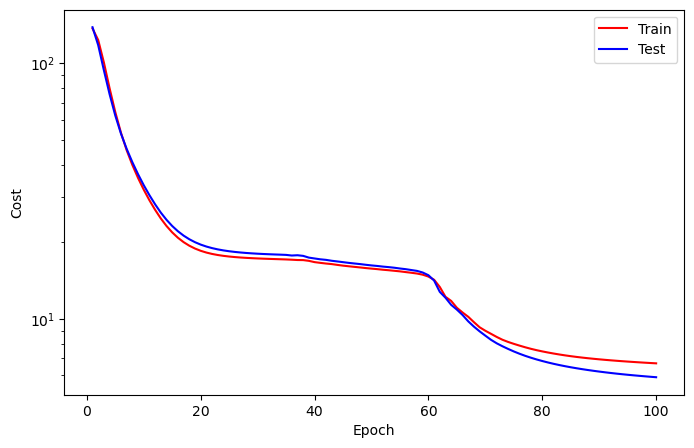

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 6.6761 | Test_cost  = 5.8849 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 6.6584 | Test_cost  = 5.8644 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 6.6414 | Test_cost  = 5.8451 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 6.6252 | Test_cost  = 5.8268 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 6.6095 | Test_cost  = 5.8094 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 6.5944 | Test_cost  = 5.7927 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 6.5798 | Test_cost  = 5.7766 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 6.5656 | Test_cost  = 5.7611 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 6.5517 | Test_cost  = 5.7460 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 6.5381 | Test_cost  = 5.7312 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 6.5248 | Test_cost  = 5.7167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 6.5118 | Test_cost  = 5.7025 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 6.4990 | Test_cost  = 5.6887 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 6.4865 | Test_cost  = 5.6751 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 6.4742 | Test_cost  = 5.6620 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 6.4622 | Test_cost  = 5.6493 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 6.4505 | Test_cost  = 5.6371 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 6.4392 | Test_cost  = 5.6254 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 6.4282 | Test_cost  = 5.6142 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 6.4175 | Test_cost  = 5.6035 | 


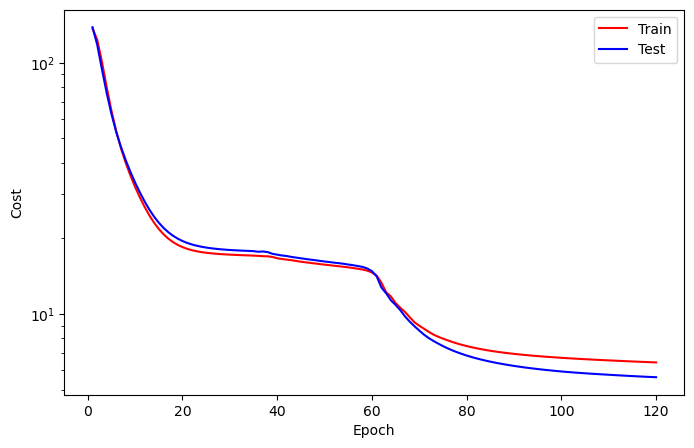

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 6.4071 | Test_cost  = 5.5932 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 6.3971 | Test_cost  = 5.5832 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 6.3873 | Test_cost  = 5.5734 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 6.3777 | Test_cost  = 5.5637 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 6.3683 | Test_cost  = 5.5541 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 6.3590 | Test_cost  = 5.5444 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 6.3500 | Test_cost  = 5.5348 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 6.3410 | Test_cost  = 5.5251 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 6.3321 | Test_cost  = 5.5154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 6.3234 | Test_cost  = 5.5058 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 6.3148 | Test_cost  = 5.4963 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 6.3062 | Test_cost  = 5.4870 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 6.2978 | Test_cost  = 5.4781 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 6.2895 | Test_cost  = 5.4694 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 6.2814 | Test_cost  = 5.4612 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 6.2734 | Test_cost  = 5.4533 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 6.2655 | Test_cost  = 5.4457 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 6.2579 | Test_cost  = 5.4386 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 6.2503 | Test_cost  = 5.4318 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 6.2430 | Test_cost  = 5.4253 | 


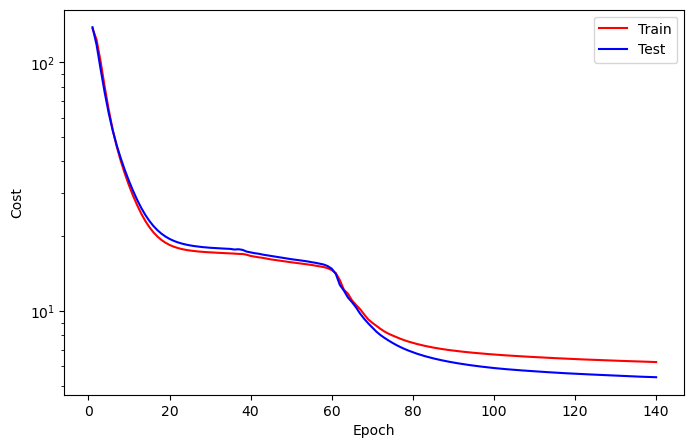

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 6.2358 | Test_cost  = 5.4191 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 6.2287 | Test_cost  = 5.4132 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 6.2218 | Test_cost  = 5.4075 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 6.2151 | Test_cost  = 5.4021 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 6.2084 | Test_cost  = 5.3970 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 6.2019 | Test_cost  = 5.3921 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 6.1954 | Test_cost  = 5.3875 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 6.1889 | Test_cost  = 5.3832 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 6.1824 | Test_cost  = 5.3792 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 6.1759 | Test_cost  = 5.3756 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 6.1695 | Test_cost  = 5.3726 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 6.1632 | Test_cost  = 5.3704 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 6.1573 | Test_cost  = 5.3694 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 6.1518 | Test_cost  = 5.3702 | 
==> EarlyStop patience =  1 | Best test_cost: 5.3694


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 6.1470 | Test_cost  = 5.3739 | 
==> EarlyStop patience =  2 | Best test_cost: 5.3694


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 6.1432 | Test_cost  = 5.3820 | 
==> EarlyStop patience =  3 | Best test_cost: 5.3694


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 6.1408 | Test_cost  = 5.3969 | 
==> EarlyStop patience =  4 | Best test_cost: 5.3694


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 6.1398 | Test_cost  = 5.4208 | 
==> EarlyStop patience =  5 | Best test_cost: 5.3694
==> Execute Early Stopping at epoch: 158 | Best test_cost: 5.3694
==> Best model is saved at model/lstm


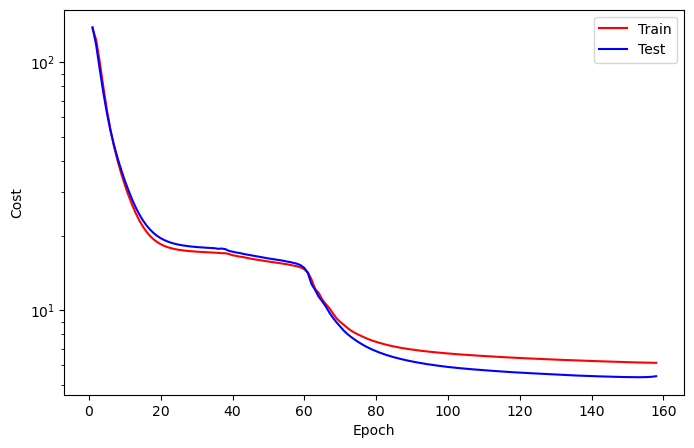

In [20]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast

In [21]:
from utils import data4pred, pred4pred

In [22]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
train_forecast_loader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
test_forecast_loader = DataLoader(test_forecast_set)


(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

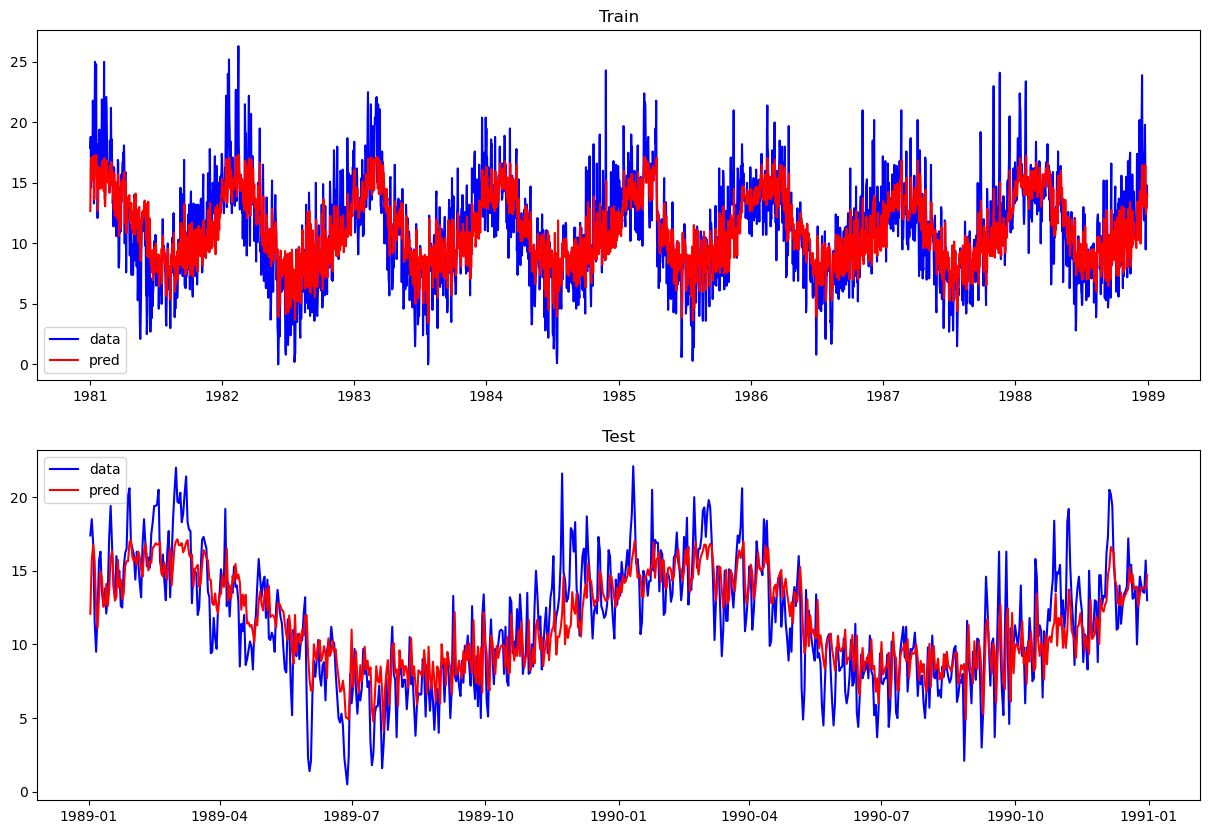

In [23]:
plt.figure(figsize=(15, 10))

# Plot untuk data training
plt.subplot(2, 1, 1)
data4pred(model, train_forecast_set, train_forecast_loader, device)
plt.title("Train")

# Plot untuk data testing
plt.subplot(2, 1, 2)
data4pred(model, test_forecast_set, test_forecast_loader, device)
plt.title("Test")

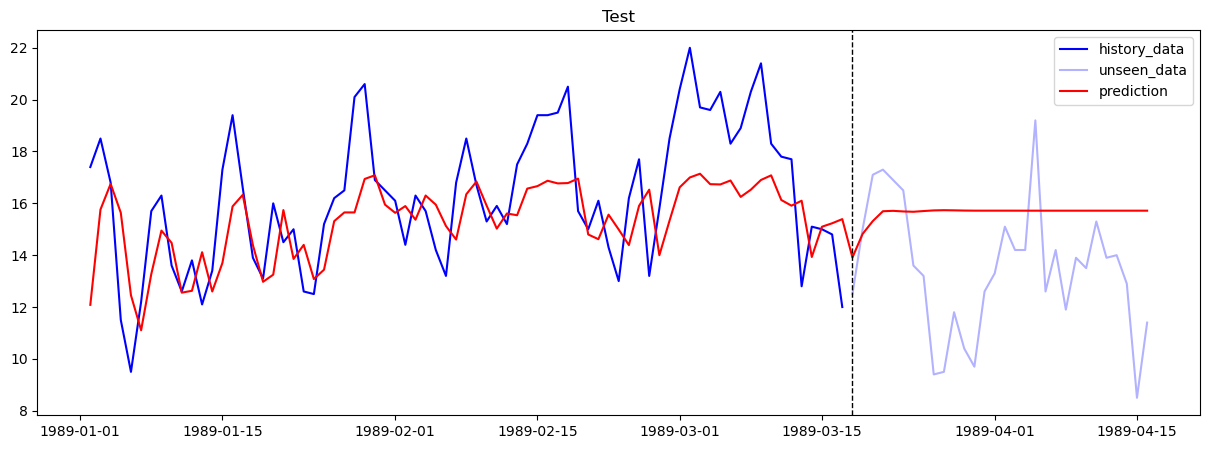

In [24]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, test_forecast_loader, device)
plt.title("Test");